# Preparando as lições para o treinamento por aprendizado de máquina

Nesse notebook, a partir de parametros estabelecidos, as lições serão preparadas para então ser realizado o treinamento, para então serem realizadas as validações e inferências do modelo para detecção de faixas de pedestre.

## Selecionando as quadrículas SCM das licoes

In [234]:
import geopandas as gpd
import pandas as pd

In [235]:
gdf_scm = gpd.read_file('zip://downloads/SIRGAS_SHP_quadriculaortofoto2017.zip!/SIRGAS_SHP_quadriculaortofoto2017/SIRGAS_SHP_quadriculaortofoto2017.shp')

In [236]:
scm_licoes = pd.read_csv('downloads/imagens/SCMs-licoes.csv')

In [237]:
# scm_licoes.loc[scm_licoes["presente"] == 1]
licoes_utilizadas = scm_licoes.loc[scm_licoes["presente"] == 1, 'scm']

In [238]:
gdf_scm[gdf_scm['qo2010_cod'].isin(licoes_utilizadas)]

,qo2010_cod,geometry
2479,3314-311,"POLYGON ((327777.044 7392618.571, 327770.250 7..."
2480,3313-432,"POLYGON ((327245.386 7392612.299, 327238.571 7..."
2484,3313-412,"POLYGON ((325118.743 7392587.016, 325111.845 7..."
2561,3313-414,"POLYGON ((325125.643 7392010.236, 325118.743 7..."
2793,3316-221,"POLYGON ((332056.790 7390360.987, 332050.159 7..."
2807,3315-211,"POLYGON ((324614.772 7390273.522, 324607.847 7..."
2808,3315-132,"POLYGON ((324083.192 7390267.129, 324076.246 7..."
3035,3325-164,"POLYGON ((336860.179 7388684.936, 336853.733 7..."
3117,3325-332,"POLYGON ((336866.626 7388108.176, 336860.179 7..."
3179,3326-424,"POLYGON ((345376.197 7387624.020, 345370.085 7..."


## Gerando as Labels de faixas de pedestre

In [239]:
licoes = gpd.read_file('licoes/licoes-por-scm.gpkg')

In [240]:
scm = '3313-414'
licoes = licoes[licoes.scm == scm]

In [241]:
len(licoes)

37

In [242]:
import rasterio
from rasterio import features
from matplotlib import pyplot
from rasterio.plot import show
# from geocube.api.core import make_geocube

In [243]:
img = "downloads/imagens/ORTO_3313-414_RGB_1000_v2.jp2"
dataset = rasterio.open(img)

In [244]:
dataset.width, dataset.height

(4522, 4893)

In [245]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint8', 2: 'uint8', 3: 'uint8'}

In [246]:
dataset.bounds

BoundingBox(left=325116.74298565835, bottom=7392008.205007771, right=325659.38298565836, top=7392595.365007771)

In [247]:
labels = features.rasterize(
            ((g, 255) for g in licoes.geometry.explode()),
            out_shape=dataset.shape,
            transform=dataset.transform)

In [248]:
labels.shape, dataset.read(1).shape

((4893, 4522), (4893, 4522))

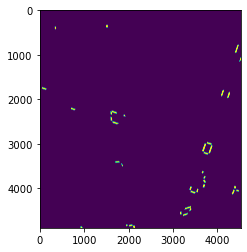

In [249]:
pyplot.imshow(labels)
pyplot.show()

In [250]:
# with rasterio.open(
#         'rasterized-results.tif', 'w',
#         driver='GTiff',
#         dtype=rasterio.uint8,
#         count=1,
#         width=dataset.width,
#         height=dataset.height,
#         transform=dataset.transform) as dst:
#     dst.write(image, indexes=1)

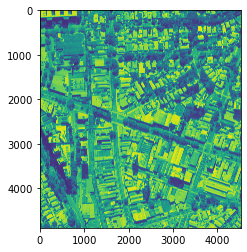

In [251]:
pyplot.imshow(dataset.read(1))
pyplot.show()

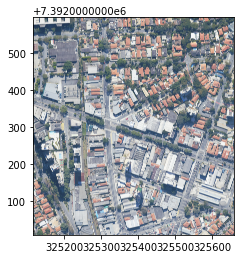

<AxesSubplot:>

In [252]:
show(dataset)

## Gerando mascaras de quadras (e copas de árvores?)

In [253]:
gdf_quadras = gpd.read_file('zip://downloads/SIRGAS_SHP_quadraMDSF.zip!/SIRGAS_SHP_quadraMDSF/SIRGAS_SHP_quadraMDSF.shp')

In [254]:
from shapely.geometry import box
gpd.GeoSeries(box(*dataset.bounds))

0    POLYGON ((325659.383 7392008.205, 325659.383 7...
dtype: geometry

In [255]:
quadras_scm = gpd.clip(gdf_quadras, gpd.GeoSeries(box(*dataset.bounds))).unary_union

In [256]:
# print(quadras_scm)

In [257]:
quadras = features.rasterize(
            ((g, 255) for g in quadras_scm),
            out_shape=dataset.shape,
            transform=dataset.transform)

In [258]:
quadras.shape, labels.shape, dataset.shape

((4893, 4522), (4893, 4522), (4893, 4522))

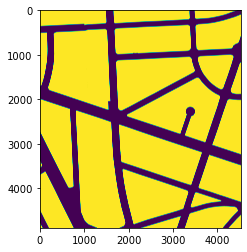

In [259]:
pyplot.imshow(quadras)

## Preparando as imagens

### Gerando GrayScale

* reescalonar?



In [260]:
grayscale = 0.2125 * dataset.read(1) + \
            0.7154 * dataset.read(2) + \
            0.0721 * dataset.read(3)

In [261]:
grayscale.astype('uint8')

array([[245, 245, 245, ..., 104,  91, 106],
       [227, 223, 220, ..., 115,  96,  83],
       [189, 192, 196, ..., 151, 111,  90],
       ...,
       [179, 183, 187, ...,  41,  45,  52],
       [180, 183, 188, ...,  50,  48,  69],
       [182, 184, 188, ...,  90,  70,  85]], dtype=uint8)

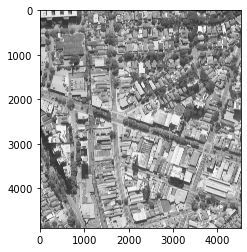

In [264]:
pyplot.imshow(grayscale.astype('uint8'), cmap='gray')

In [263]:
with rasterio.open(
        'tmp/grayscale-results.tif', 'w',
        driver='GTiff',
        dtype=rasterio.uint8,
        count=1,
        width=dataset.width,
        height=dataset.height,
        transform=dataset.transform) as dst:
    dst.write(grayscale.astype('uint8'), indexes=1)

### Gerando HOG e Local Binary Pattern (LBPH)

In [265]:
from skimage.feature import hog

In [266]:
fd, hog_image = hog(grayscale, orientations=8, visualize=True, 
                    pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1))

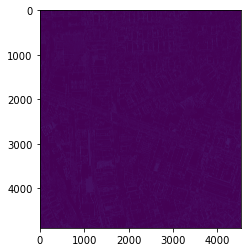

In [267]:
pyplot.imshow(hog_image)

In [302]:
from skimage.feature import local_binary_pattern

In [331]:
radius = 3
n_points = 8 * radius

In [332]:
lbp = local_binary_pattern(grayscale, n_points, radius)

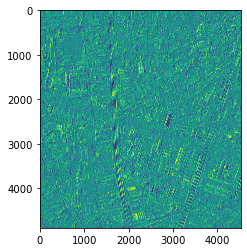

In [333]:
pyplot.imshow(lbp)

## Gerando as lições 

Considera lição se a condiçao for:

* mais de 80% dos pixels dentro da lição
* mais de 20% dos pixels estiver fora da quadra viária
* 100% dos pixels dentro do SCM

### DAta Augmentation das lições das faixas de pedestre

* Rotate 0, 90, 180, 270 
* Cada rotate Flip H e V
* 16 possibilidades de Augmentation
* (Talvez um rotation a cada 15 graus, 6 possibilides, aumentando total para 96 possibilidades)

In [268]:
tamanho_janela = 24 # tamanho em pixels
sobreposicao_de_janelas = 16 # sobreposição das janelas em pixels

In [269]:
grayscale = grayscale.astype('uint8')

In [270]:
import numpy as np

<function ndarray.squeeze>

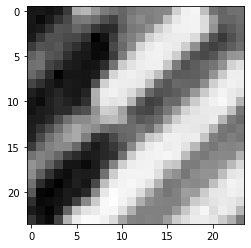

In [295]:
# 4864 920
pyplot.imshow(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela], cmap='gray')

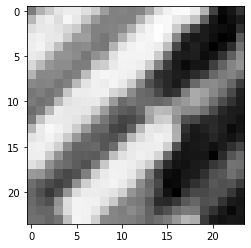

In [341]:
pyplot.imshow(np.flip(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela]), cmap='gray')

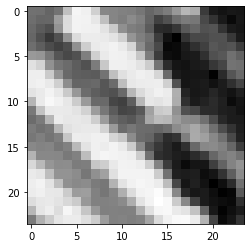

In [343]:
# pyplot.imshow(np.flipud(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela]), cmap='gray')
pyplot.imshow(np.fliplr(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela]), cmap='gray')

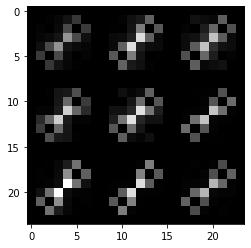

In [338]:
pyplot.imshow(hog_image[4864:4864+tamanho_janela, 920:920+tamanho_janela], cmap='gray')

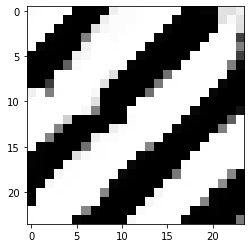

In [337]:
pyplot.imshow(lbp[4864:4864+tamanho_janela, 920:920+tamanho_janela], cmap='gray')

In [344]:
# lbp[4864:4864+tamanho_janela, 920:920+tamanho_janela]

In [340]:
rua = 0
faixa = 0

for i in np.arange(0, grayscale.shape[0] - tamanho_janela, tamanho_janela - sobreposicao_de_janelas):
    for j in np.arange(0, grayscale.shape[1] - tamanho_janela, tamanho_janela - sobreposicao_de_janelas):
        # Se mais de 80% dos pixels estiverem fora da quadra
        if np.count_nonzero(quadras[i:i+tamanho_janela, j:j+tamanho_janela] == 255) < 0.80 * (tamanho_janela ** 2):
            # print(i, j)
            # Se mais de 80% dos pixels estiverem dentro de um label de faixa de pedestre
            rua += 1
            if np.count_nonzero(labels[i:i+tamanho_janela, j:j+tamanho_janela] == 255) > 0.80 * (tamanho_janela ** 2):
                # print(i, j)
                faixa += 1
                
                # Data Augmentation
                # flip
                # rotate

print(f"{rua} ruas e {faixa} faixas")

336 1488
336 1496
336 1504
344 1488
344 1496
344 1504
352 1488
352 1496
352 1504
360 1488
360 1496
360 1504
368 336
368 1488
368 1496
368 1504
376 328
376 336
376 344
384 328
384 336
384 344
392 328
392 336
392 344
400 328
400 336
400 344
408 328
408 336
408 344
784 4440
784 4448
792 4432
792 4440
792 4448
800 4432
800 4440
808 4424
808 4432
808 4440
816 4424
816 4432
816 4440
824 4424
824 4432
832 4416
832 4424
832 4432
840 4416
840 4424
840 4432
848 4416
848 4424
856 4408
856 4416
856 4424
864 4408
864 4416
864 4424
872 4408
872 4416
880 4400
880 4408
880 4416
888 4400
888 4408
888 4416
896 4400
896 4408
904 4392
904 4400
904 4408
912 4392
912 4400
912 4408
920 4392
920 4400
928 4384
928 4392
928 4400
936 4384
936 4392
936 4400
1088 4496
1096 4496
1104 4496
1112 4488
1112 4496
1120 4488
1120 4496
1736 40
1736 48
1736 56
1736 64
1744 40
1744 48
1744 56
1744 64
1744 72
1744 80
1744 88
1752 56
1752 64
1752 72
1752 80
1752 88
1752 96
1752 104
1752 112
1760 80
1760 88
1760 96
1760 104
176